In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload 

from sklearn import metrics
import seaborn as sns
sns.set()


from IPython.display import clear_output, display

In [2]:
from preproc_functions import pre_process

In [3]:
from model_functions import SplitModel

## Walk forward

In [4]:
def progress_bar(k, n, incr_txt="Step", bar_len = 10):
   
    bar_char  = u'\u25A5'
    line_char = u'\u21E2' # u'\u2192'  u'\u23AF' u'\u25AD'
    
    places   = int(np.ceil(n/bar_len))
    pct      = k/n
    n_str    = "{:,.0f}".format(n)        
    k_str    = "{:,.0f}".format(k)
    pct_str  = "{:,.0f}%".format(k/n * 100)
    # d_format = "%" + str(places) + "d"
    
    if k == n-1:
        n_bars = bar_len
        n_spaces = 0
        text_txt = "Completed " + n_str + " " + incr_txt + "s."
    else:
        n_bars   = int(np.floor(pct * bar_len))
        n_spaces = bar_len - n_bars
        text_txt = " " + pct_str +  " (" + incr_txt + " " + k_str + " of  " + n_str + ")."

    bar_txt  = "[" + "".ljust(n_bars,bar_char) + "".rjust(n_spaces,line_char) + "]  " 

    clear_output()
    display(bar_txt + text_txt)

In [5]:
def walk_forward_harness(df, start, date_col = 'Date', step_size = 1):     
    predictions = []
    model_list = []
    group_list = []
    
    stats_list = []
    def_percent = []

    labels = []

    ### features for first firm
    first_features = [
        # 'asst_tot_quantile_values', ####
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        # 'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        # 'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values', ####
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda',
        # 'ateco_sector_pd',
        # 'sector_group_pd', ####
        # 'legal_struct_pd',
        'regional_code_pd' ####
    ]


    ### features for recurring firms
    rec_features = [
        # 'asst_tot_quantile_values', ###
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values',###
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda', ###
        # 'ateco_sector_pd',###
        # 'sector_group_pd',###
        # 'legal_struct_pd',###
        'regional_code_pd'
    ]


    with open('quantile_custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)
    
    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {},
        'category_pd':{}
    }
    
    # df[date_col] = pd.to_datetime(df[date_col])
    # walk_range = df[date_col].dt.year.unique()
    walk_range = df['fs_year'].unique()
    
    for i in range(start,len(walk_range), step_size):
        print(stats_list)
        
        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]
        print('Training range:',train_idx)
        print('Test step:',test_idx)

        # print('train',train_idx)
        # print('test',test_idx)
        
        # train_data = df[df[date_col].dt.year.isin(train_idx)].copy()
        # test_data = df[df[date_col].dt.year.isin(test_idx)].copy()
        train_data = df[df['fs_year'].isin(train_idx)].copy()
        test_data = df[df['fs_year'].isin(test_idx)].copy()
        print(train_data.shape)
        print(test_data.shape)

        train_data_proc , preproc_params = pre_process(train_data, 
                                                       custom_bins=custom_bins, 
                                                       preproc_params = preproc_params,  
                                                       quantiles = 50, 
                                                       days_until_statement = 150)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        test_data_proc , preproc_params = pre_process(test_data, 
                                                     historical_df=train_data_proc, 
                                                     new=False, 
                                                     preproc_params = preproc_params,  
                                                     quantiles = 50, 
                                                     days_until_statement = 150)
        print(train_data_proc['default'].mean())
        print(test_data_proc['default'].mean())

        # print(train_data_proc['is_first_occurrence'].value_counts())
        # print(test_data_proc['is_first_occurrence'].value_counts())

        

        model = SplitModel(algo=smf.probit, first_features=first_features, rec_features=rec_features)
        model.train(train_data_proc)
        
        prediction = model.predict(test_data_proc)
        
        labels += list(test_data_proc['default'].values)
        predictions += list(prediction.values)
        group_list += test_idx * len(prediction)
        
        preds = pd.DataFrame([labels,predictions,group_list]).T
        preds.columns = ['label','prediction','group']
        
        score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])
        
        stats_list.append(score)
        model_list.append(model)

        progress_bar(i, len(walk_range))
    
    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)

In [6]:
modeling_df = pd.read_csv('../data/train.csv', index_col=0)
modeling_df.shape

(1023552, 43)

In [7]:
modeling_df['stmt_date'] = pd.to_datetime(modeling_df['stmt_date'])
modeling_df['def_date'] = pd.to_datetime(modeling_df['def_date'], format="%d/%m/%Y")

In [8]:
### we'll try dropping NA's for now
# modeling_df = modeling_df[~(modeling_df[features].isna().sum(axis=1)>0)].copy()
modeling_df.sort_values('stmt_date', inplace=True)

In [9]:
features_needed = ['id',
                     'stmt_date',
                     'HQ_city',
                     # 'legal_struct',
                     'ateco_sector',
                     'def_date',
                     'fs_year',
                     # 'asst_intang_fixed',
                     # 'asst_tang_fixed',
                     # 'asst_fixed_fin',
                     # 'asst_current',
                     'AR',
                     'cash_and_equiv',
                     'asst_tot',
                     'eqty_tot',
                     # 'eqty_corp_family_tot',
                     # 'liab_lt',
                     # 'liab_lt_emp',
                     # 'debt_bank_st',
                     # 'debt_bank_lt',
                     # 'debt_fin_st',
                     # 'debt_fin_lt',
                     # 'AP_st',
                     # 'AP_lt',
                     'debt_st',
                     'debt_lt',
                     'rev_operating',
                     # 'COGS',
                     'prof_operations',
                     # 'goodwill',
                     # 'inc_financing',
                     'exp_financing',
                     # 'prof_financing',
                     # 'inc_extraord',
                     # 'taxes',
                     'profit',
                     # 'days_rec',
                     'ebitda',
                     # 'roa',
                     # 'roe',
                     # 'wc_net',
                     # 'margin_fin',
                     # 'cf_operations'
                  ]

In [10]:
features_needed

['id',
 'stmt_date',
 'HQ_city',
 'ateco_sector',
 'def_date',
 'fs_year',
 'AR',
 'cash_and_equiv',
 'asst_tot',
 'eqty_tot',
 'debt_st',
 'debt_lt',
 'rev_operating',
 'prof_operations',
 'exp_financing',
 'profit',
 'ebitda']

In [11]:
# modeling_df = modeling_df[features_needed]

In [12]:
modeling_df['def_date'] = pd.to_datetime(modeling_df['def_date'], format="%d/%m/%Y")

In [13]:
predictions, model_list, stats_list = walk_forward_harness(modeling_df,
                                                           date_col = 'stmt_date',
                                                           start = 2, 
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 6 Steps.'

In [14]:
# predictions = predictions.dropna()

ROC AUC 0.7924521386487089


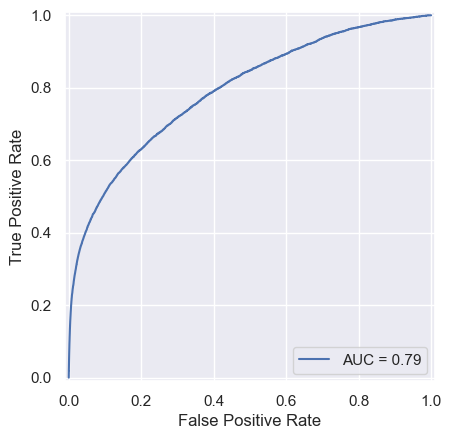

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(predictions['label'], predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

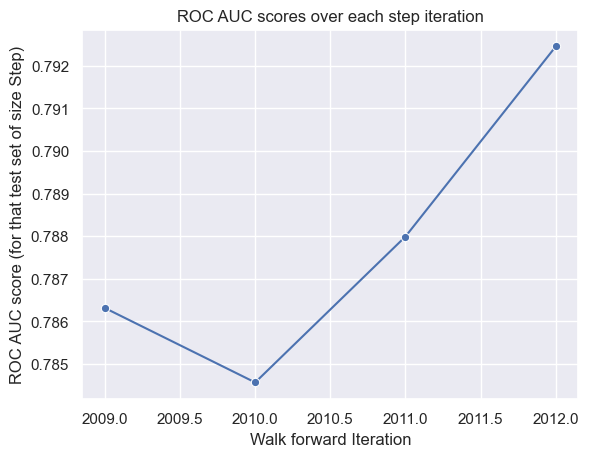

In [16]:
sns.lineplot(x=predictions['group'].unique(), y=stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [17]:
default_data_viz = predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

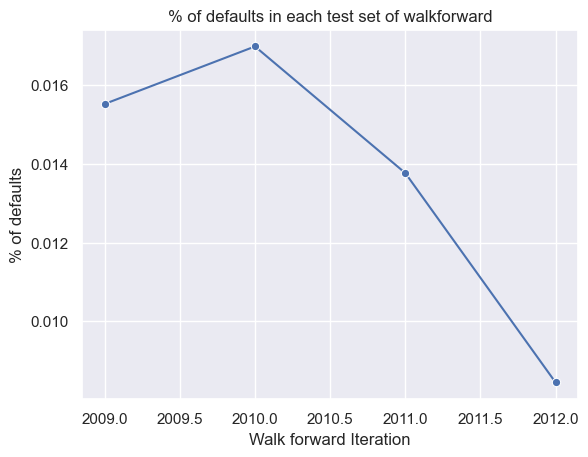

In [18]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')

In [19]:
stats_list[-1]

np.float64(0.7924521386487089)

In [20]:
last_model = model_list[-1]

In [21]:
print(last_model.rec_fitted_model.summary())

                          Probit Regression Results                           
Dep. Variable:                default   No. Observations:               612920
Model:                         Probit   Df Residuals:                   612910
Method:                           MLE   Df Model:                            9
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                  0.1815
Time:                        15:58:37   Log-Likelihood:                -38699.
converged:                       True   LL-Null:                       -47280.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.3959      0.029   -116.954      0.000      -3.453      -3.339
financial_leverage_quantile_values      1.9607      0.10

In [22]:
print(last_model.first_fitted_model.summary())

                          Probit Regression Results                           
Dep. Variable:                default   No. Observations:               224993
Model:                         Probit   Df Residuals:                   224985
Method:                           MLE   Df Model:                            7
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                  0.1104
Time:                        15:58:37   Log-Likelihood:                -11353.
converged:                       True   LL-Null:                       -12761.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.1272      0.051    -61.891      0.000      -3.226      -3.028
financial_leverage_quantile_values      2.2339      0.20

In [23]:
for year in predictions['group'].unique():
    preds = predictions[predictions['group']==year]['prediction']
    true = predictions[predictions['group']==year]['label']
    print(year, metrics.roc_auc_score(y_true=true, y_score=preds))

2009.0 0.7863160007949944
2010.0 0.7844445138459164
2011.0 0.8019191718267438
2012.0 0.844809502023343


# XGBoost WF

In [24]:
from xgboost import XGBClassifier

In [28]:
def walk_forward_xgb(df, start, date_col = 'Date', step_size = 1):     
    predictions = []
    model_list = []
    group_list = []
    
    stats_list = []
    def_percent = []

    labels = []

    ### features for first firm
    first_features = [
        # 'asst_tot_quantile_values', ####
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        # 'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        # 'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values', ####
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda',
        # 'ateco_sector_pd',
        # 'sector_group_pd', ####
        # 'legal_struct_pd',
        'regional_code_pd' ####
    ]


    ### features for recurring firms
    rec_features = [
        # 'asst_tot_quantile_values', ###
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values',###
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda', ###
        # 'ateco_sector_pd',###
        # 'sector_group_pd',###
        # 'legal_struct_pd',###
        'regional_code_pd'
    ]


    with open('quantile_custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)
    
    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {},
        'category_pd': {}
    }
    
    # df[date_col] = pd.to_datetime(df[date_col])
    # walk_range = df[date_col].dt.year.unique()
    walk_range = df['fs_year'].unique()
    
    for i in range(start,len(walk_range), step_size):
        print(stats_list)
        
        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]
        print('Training range:',train_idx)
        print('Test step:',test_idx)

        # print('train',train_idx)
        # print('test',test_idx)
        
        # train_data = df[df[date_col].dt.year.isin(train_idx)].copy()
        # test_data = df[df[date_col].dt.year.isin(test_idx)].copy()
        train_data = df[df['fs_year'].isin(train_idx)].copy()
        test_data = df[df['fs_year'].isin(test_idx)].copy()
        print(train_data.shape)
        print(test_data.shape)

        train_data_proc , preproc_params = pre_process(train_data, 
                                                       custom_bins=custom_bins, 
                                                       preproc_params = preproc_params,  
                                                       quantiles = 50, 
                                                       days_until_statement = 150)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        test_data_proc , preproc_params = pre_process(test_data, 
                                                     historical_df=train_data_proc, 
                                                     new=False, 
                                                     preproc_params = preproc_params,  
                                                     quantiles = 50, 
                                                     days_until_statement = 150)
        print(train_data_proc['default'].mean())
        print(test_data_proc['default'].mean())

        # print(train_data_proc['is_first_occurrence'].value_counts())
        # print(test_data_proc['is_first_occurrence'].value_counts())
        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "eta": 0.1,
            "max_depth": 4,
            "min_child_weight": 1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "gamma": 0,
            "alpha": 0.1,
            "lambda": .1,
            "n_estimators":250
         }
        
        rec_bst = XGBClassifier(**params)
        first_bst = XGBClassifier(**params)

        rec_train_data = train_data_proc[train_data_proc['is_first_occurrence']==0]
        first_train_data = train_data_proc[train_data_proc['is_first_occurrence']==1]
        
        rec_test_data = test_data_proc[test_data_proc['is_first_occurrence']==0]
        first_test_data = test_data_proc[test_data_proc['is_first_occurrence']==1]

        
        rec_bst = rec_bst.fit(X=rec_train_data[rec_features], 
                   y=rec_train_data['default'])

        first_bst = first_bst.fit(X=first_train_data[first_features], 
                           y=first_train_data['default'])

        
        rec_preds = rec_bst.predict_proba(rec_test_data[rec_features])[:,1]
        rec_test_results = rec_test_data[['default']].copy()
        rec_test_results['predictions'] = rec_preds
        
        first_preds = first_bst.predict_proba(first_test_data[first_features])[:,1]
        first_test_results = first_test_data[['default']].copy()
        first_test_results['predictions'] = first_preds

        prediction = pd.concat([rec_test_results,first_test_results]).reindex(test_data_proc.index)

        model = (rec_bst,first_bst)
        
        labels += list(prediction['default'].values)
        predictions += list(prediction['predictions'].values)
        group_list += test_idx * len(prediction)
        
        preds = pd.DataFrame([labels,predictions,group_list]).T
        preds.columns = ['label','prediction','group']
        
        score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])
        
        stats_list.append(score)
        model_list.append(model)

        progress_bar(i, len(walk_range))
    
    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)

In [29]:
xgb_predictions, xgb_model_list, xgb_stats_list = walk_forward_xgb(modeling_df,
                                                           date_col = 'stmt_date',
                                                           start = 2, 
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 6 Steps.'

ROC AUC 0.8188496619034102


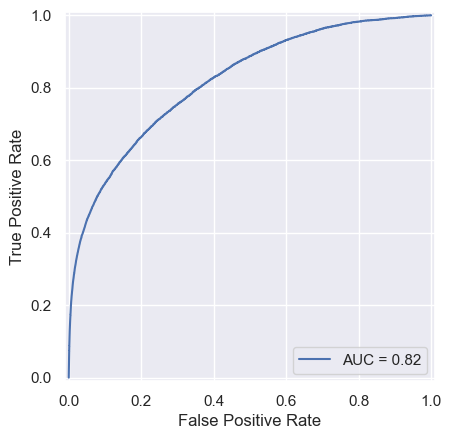

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(xgb_predictions['label'], xgb_predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

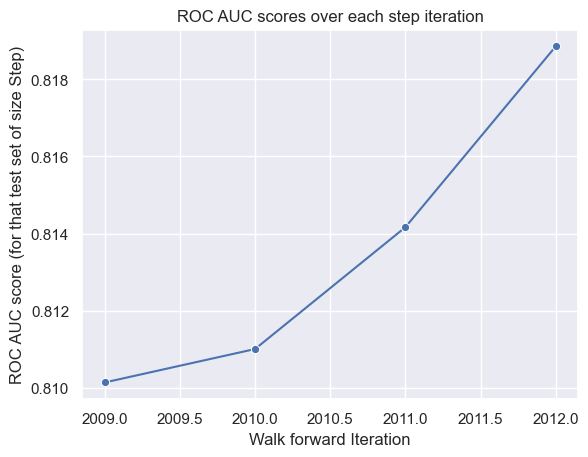

In [31]:
sns.lineplot(x=xgb_predictions['group'].unique(), y=xgb_stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [32]:
default_data_viz = xgb_predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

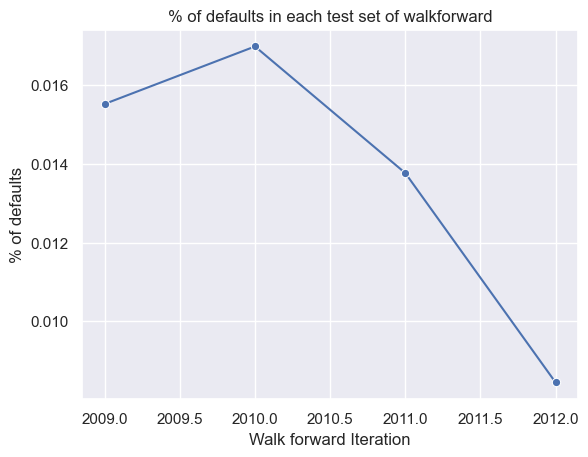

In [33]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')

In [34]:
xgb_stats_list[-1]

np.float64(0.8188496619034102)

In [35]:
last_model = xgb_model_list[-1]

In [36]:
for year in xgb_predictions['group'].unique():
    preds = xgb_predictions[xgb_predictions['group']==year]['prediction']
    true = xgb_predictions[xgb_predictions['group']==year]['label']
    print(year, metrics.roc_auc_score(y_true=true, y_score=preds))

2009.0 0.8101449715112661
2010.0 0.8123303373722874
2011.0 0.8256805428538643
2012.0 0.8666052142535062


# Comparison

In [37]:
# xgb_predictions

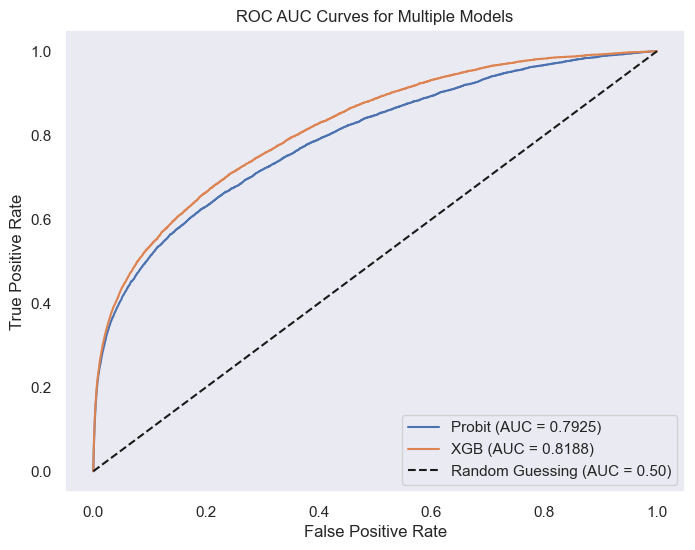

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming df1, df2, and df3 are your three DataFrames with true labels and predictions
dataframes = [predictions ,xgb_predictions,]
labels = ["Probit", "XGB"]

plt.figure(figsize=(8, 6))

for i, df in enumerate(dataframes):
    # Replace 'true_labels' and 'predictions' with the actual column names in your DataFrames
    fpr, tpr, _ = roc_curve(df['label'], df['prediction'])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for the current model
    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.4f})")

# Plot the random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')

# Labels, title, and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curves for Multiple Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()